In [97]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


plt.style.use('seaborn-v0_8-whitegrid')
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


# Load the data
This project is an effort to see if the spring increase in discharge can be predicted from publicly available streamflow data.

The Yellowstone river was selected as it is an undammed river with readily accessible data. 

The data is from the Yellowstone river at Livingston MT. The data is from the USGS and is available at https://waterdata.usgs.gov/mt/nwis/uv?site_no=06192500


In [98]:
discharge_data=pd.read_csv('yellowstone6192500.csv')

discharge_data['datetime'] = pd.to_datetime(discharge_data['datetime'])

print(discharge_data.head())


  agency_cd         id            datetime timezone discharge
0      USGS  6192500.0 1995-10-01 00:15:00      MDT      2210
1      USGS  6192500.0 1995-10-01 00:30:00      MDT      2210
2      USGS  6192500.0 1995-10-01 00:45:00      MDT      2200
3      USGS  6192500.0 1995-10-01 01:00:00      MDT      2210
4      USGS  6192500.0 1995-10-01 01:15:00      MDT      2200


/tmp/ipykernel_823090/1465887672.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  discharge_data=pd.read_csv('yellowstone6192500.csv')


In [99]:
print(discharge_data.tail())

       agency_cd         id            datetime timezone discharge
984697      USGS  6192500.0 2025-03-17 03:15:00      MDT      1160
984698      USGS  6192500.0 2025-03-17 03:30:00      MDT      1170
984699      USGS  6192500.0 2025-03-17 03:45:00      MDT      1160
984700      USGS  6192500.0 2025-03-17 04:00:00      MDT      1180
984701       NaN        NaN                 NaT      NaN       NaN


In [100]:
snow_data=pd.read_csv('snotel_data.csv')

snow_data['datetime'] = pd.to_datetime(snow_data['date'])

print(snow_data.head())

         date  value   datetime
0  1995-10-01    0.0 1995-10-01
1  1995-10-02    0.0 1995-10-02
2  1995-10-03    0.4 1995-10-03
3  1995-10-04    0.4 1995-10-04
4  1995-10-05    0.4 1995-10-05


In [101]:
print(snow_data.tail())

             date  value   datetime
10749  2025-03-12   10.2 2025-03-12
10750  2025-03-13   10.5 2025-03-13
10751  2025-03-14   10.6 2025-03-14
10752  2025-03-15   10.7 2025-03-15
10753  2025-03-16   11.0 2025-03-16


In [102]:
noaa_data=pd.read_csv('noaa_data.csv')

noaa_data['datetime'] = pd.to_datetime(noaa_data['date'])

print(noaa_data.head())

         date      station   tmin  tmax  tavg   prcp   wesd   datetime
0  1995-10-01  USS0010E03S  -71.0  62.0  -1.0    0.0    0.0 1995-10-01
1  1995-10-02  USS0010E03S -117.0  73.0 -21.0    0.0    0.0 1995-10-02
2  1995-10-03  USS0010E03S  -20.0  18.0  -3.0  102.0  102.0 1995-10-03
3  1995-10-04  USS0010E03S  -48.0  -2.0 -25.0    0.0  102.0 1995-10-04
4  1995-10-05  USS0010E03S  -99.0  24.0 -40.0    0.0  102.0 1995-10-05


In [103]:
print(noaa_data.tail())

             date      station  tmin  tmax  tavg  prcp  wesd   datetime
10611  2025-03-07  USS0010E03S  -1.0  32.0  15.0   0.0  10.2 2025-03-07
10612  2025-03-08  USS0010E03S   8.0  38.0  22.0   0.0  10.2 2025-03-08
10613  2025-03-09  USS0010E03S  19.0  40.0  27.0   0.0  10.2 2025-03-09
10614  2025-03-10  USS0010E03S  15.0  38.0  26.0   0.0  10.2 2025-03-10
10615  2025-03-11  USS0010E03S  15.0  40.0  26.0   0.0  10.2 2025-03-11


In [104]:
# Convert the datetime column to date only
discharge_data['date'] = discharge_data['datetime'].dt.date

# Convert the discharge column to numeric, coercing errors to NaN
discharge_data['discharge'] = pd.to_numeric(discharge_data['discharge'], errors='coerce')

# Compute the mean discharge for each day
daily_mean_discharge = discharge_data.groupby('date')['discharge'].mean().reset_index()

# Create a new dataframe with the date and mean discharge
data = daily_mean_discharge

print(data.head())
print(data.tail())

         date    discharge
0  1995-10-01  2205.894737
1  1995-10-02  2180.729167
2  1995-10-03  2149.479167
3  1995-10-04  2253.229167
4  1995-10-05  2241.770833
             date    discharge
10355  2025-03-13  1097.526882
10356  2025-03-14  1172.659574
10357  2025-03-15  1159.255319
10358  2025-03-16  1142.872340
10359  2025-03-17  1164.705882


In [105]:
data['date'] = pd.to_datetime(data['date'])

# Find the most recent date in each dataframe
latest_date_noaa = noaa_data['datetime'].max()
latest_date_data = data['date'].max()
latest_date_snow = snow_data['datetime'].max()

# Determine the least recent date
least_recent_date = min(latest_date_noaa, latest_date_data, latest_date_snow)

# Filter the dataframes to only include dates up to the least recent date
noaa_data = noaa_data[noaa_data['datetime'] <= least_recent_date]
data = data[data['date'] <= least_recent_date]
snow_data = snow_data[snow_data['datetime'] <= least_recent_date]

# Print the most recent dates after filtering
print(f"Most recent date in noaa_data: {noaa_data['datetime'].max()}")
print(f"Most recent date in data: {data['date'].max()}")
print(f"Most recent date in snow_data: {snow_data['datetime'].max()}")

Most recent date in noaa_data: 2025-03-11 00:00:00
Most recent date in data: 2025-03-11 00:00:00
Most recent date in snow_data: 2025-03-11 00:00:00


In [106]:
# Merge snow_data with data on the 'date' column
data = pd.merge(data, snow_data[['datetime', 'value']], left_on='date', right_on='datetime', how='left')

# Rename the 'value' column to 'snow_value' for clarity
data.rename(columns={'value': 'snow_value'}, inplace=True)

print(data.head())

        date    discharge   datetime  snow_value
0 1995-10-01  2205.894737 1995-10-01         0.0
1 1995-10-02  2180.729167 1995-10-02         0.0
2 1995-10-03  2149.479167 1995-10-03         0.4
3 1995-10-04  2253.229167 1995-10-04         0.4
4 1995-10-05  2241.770833 1995-10-05         0.4


In [107]:
# Merge noaa_data with data on the 'date' column
data = pd.merge(data, noaa_data[['datetime', 'tmin', 'tmax', 'tavg', 'prcp', 'wesd']], left_on='date', right_on='datetime', how='left')

# Print the first few rows of the merged dataframe
print(data.head())

        date    discharge datetime_x  snow_value datetime_y   tmin  tmax  \
0 1995-10-01  2205.894737 1995-10-01         0.0 1995-10-01  -71.0  62.0   
1 1995-10-02  2180.729167 1995-10-02         0.0 1995-10-02 -117.0  73.0   
2 1995-10-03  2149.479167 1995-10-03         0.4 1995-10-03  -20.0  18.0   
3 1995-10-04  2253.229167 1995-10-04         0.4 1995-10-04  -48.0  -2.0   
4 1995-10-05  2241.770833 1995-10-05         0.4 1995-10-05  -99.0  24.0   

   tavg   prcp   wesd  
0  -1.0    0.0    0.0  
1 -21.0    0.0    0.0  
2  -3.0  102.0  102.0  
3 -25.0    0.0  102.0  
4 -40.0    0.0  102.0  


In [108]:
data.drop(columns=['datetime_x', 'datetime_y'], inplace=True)
print(data.head())

        date    discharge  snow_value   tmin  tmax  tavg   prcp   wesd
0 1995-10-01  2205.894737         0.0  -71.0  62.0  -1.0    0.0    0.0
1 1995-10-02  2180.729167         0.0 -117.0  73.0 -21.0    0.0    0.0
2 1995-10-03  2149.479167         0.4  -20.0  18.0  -3.0  102.0  102.0
3 1995-10-04  2253.229167         0.4  -48.0  -2.0 -25.0    0.0  102.0
4 1995-10-05  2241.770833         0.4  -99.0  24.0 -40.0    0.0  102.0


# Data Cleaning and Preprocessing

In [109]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10354 entries, 0 to 10353
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        10354 non-null  datetime64[ns]
 1   discharge   10136 non-null  float64       
 2   snow_value  10348 non-null  float64       
 3   tmin        10113 non-null  float64       
 4   tmax        10213 non-null  float64       
 5   tavg        10213 non-null  float64       
 6   prcp        10192 non-null  float64       
 7   wesd        10214 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 647.3 KB


In [110]:
data.isnull().sum()

date            0
discharge     218
snow_value      6
tmin          241
tmax          141
tavg          141
prcp          162
wesd          140
dtype: int64

In [111]:
data.dropna(inplace=True)
print(data.isnull().sum())

date          0
discharge     0
snow_value    0
tmin          0
tmax          0
tavg          0
prcp          0
wesd          0
dtype: int64


In [112]:
# Define the start and end dates for the winter season
start_date = '1995-10-01'
end_date = '2025-06-22'

# Filter the snow_data to include only the winter season dates
winter_snow_data = snow_data[(snow_data['datetime'] >= start_date) & (snow_data['datetime'] <= end_date)]

# Create a new column for the year of the winter season
winter_snow_data['winter_year'] = winter_snow_data['datetime'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)

# Identify the first snowfall date for each winter season
first_snowfall_dates = winter_snow_data[winter_snow_data['value'] > 0].groupby('winter_year')['datetime'].min().reset_index()

# Merge the first snowfall dates with the winter_snow_data
winter_snow_data = pd.merge(winter_snow_data, first_snowfall_dates, on='winter_year', suffixes=('', '_first'))

# Filter the data to include only dates from the first snowfall to June 22 of the following year
winter_snow_data = winter_snow_data[winter_snow_data['datetime'] >= winter_snow_data['datetime_first']]
winter_snow_data = winter_snow_data[winter_snow_data['datetime'] <= winter_snow_data['winter_year'].apply(lambda x: pd.Timestamp(f'{x+1}-06-22'))]

# Calculate the snowfall accumulation for each winter season
snowfall_accumulation = winter_snow_data.groupby('winter_year')['value'].sum().reset_index()
snowfall_accumulation.rename(columns={'value': 'snowfall_accumulation'}, inplace=True)

print(snowfall_accumulation)

    winter_year  snowfall_accumulation
0          1995                 2969.1
1          1996                 3264.2
2          1997                 1484.8
3          1998                 2310.3
4          1999                 1439.0
5          2000                 1080.4
6          2001                 1685.2
7          2002                 1668.5
8          2003                 1308.6
9          2004                 1102.7
10         2005                 1851.6
11         2006                 1340.1
12         2007                 2415.5
13         2008                 1739.4
14         2009                 1165.3
15         2010                 2641.3
16         2011                 1442.7
17         2012                 1374.7
18         2013                 1809.5
19         2014                 1280.6
20         2015                 1182.4
21         2016                 2148.3
22         2017                 2134.0
23         2018                 1561.2
24         2019          

<Axes: xlabel='date'>

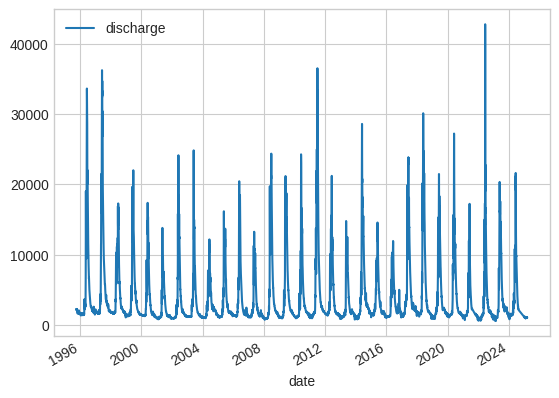

In [113]:
# Plot the data
data.plot(x='date', y='discharge')

<Axes: xlabel='date'>

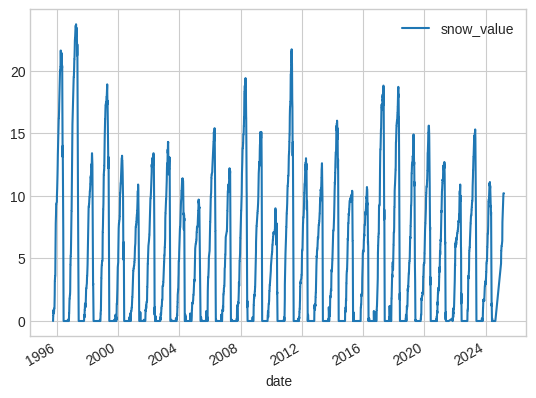

In [114]:
data.plot(x='date', y='snow_value')

<Axes: xlabel='date'>

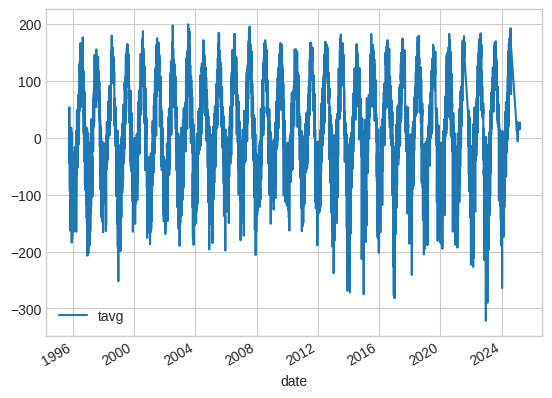

In [115]:
data.plot(x='date', y='tavg')

From this chart we can see that there is indeed an increase of discharge every spring.  However, the magnitude of this increase varies quite a bit from year to year.

In [116]:
data['year']=data['date'].dt.year

data.head()

,date,discharge,snow_value,tmin,tmax,tavg,prcp,wesd,year
0,1995-10-01,2205.894737,0.0,-71.0,62.0,-1.0,0.0,0.0,1995
1,1995-10-02,2180.729167,0.0,-117.0,73.0,-21.0,0.0,0.0,1995
2,1995-10-03,2149.479167,0.4,-20.0,18.0,-3.0,102.0,102.0,1995
3,1995-10-04,2253.229167,0.4,-48.0,-2.0,-25.0,0.0,102.0,1995
4,1995-10-05,2241.770833,0.4,-99.0,24.0,-40.0,0.0,102.0,1995


In [117]:
data.groupby(['year']).mean(numeric_only=True)

,discharge,snow_value,tmin,tmax,tavg,prcp,wesd
year,,,,,,,
1995,1907.045078,3.533333,-102.370370,13.765432,-44.432099,34.432099,897.432099
1996,5980.017821,7.086817,-58.459807,97.286174,19.430868,23.321543,1800.028939
1997,6775.312076,7.710154,-54.350769,93.870769,18.190769,16.670769,1958.378462
1998,4220.642372,4.155493,-45.343662,89.769014,20.481690,20.033803,1055.512676
1999,4371.230284,6.223851,-57.140805,92.459770,17.508621,18.640805,1580.890805
2000,3394.376057,3.946784,-52.616959,95.479532,21.771930,18.055556,1002.485380
2001,2499.682326,3.043976,-50.475904,103.753012,26.825301,15.325301,773.174699
2002,3748.841059,3.870740,-48.109325,99.524116,25.636656,15.028939,983.170418
2003,3550.882174,4.266463,-41.457317,103.585366,32.676829,16.048780,1083.676829


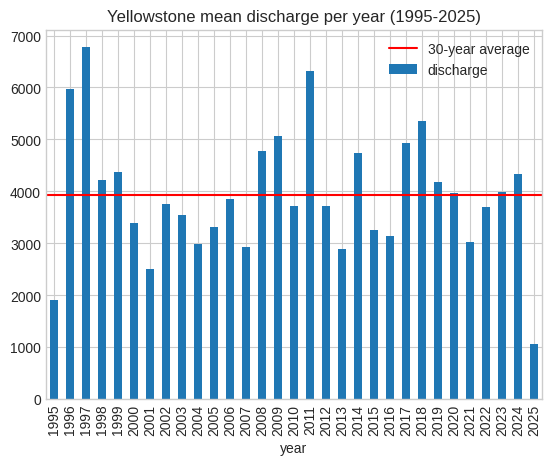

In [118]:
means = data.groupby(['year']).mean(numeric_only=True)
mean_discharge = means['discharge']
overall_mean = mean_discharge.mean()

mean_discharge.plot(kind='bar')
plt.axhline(y=overall_mean, color='red', label='30-year average')
plt.title("Yellowstone mean discharge per year (1995-2025)")
plt.legend()
plt.show()


In [119]:
data['year']

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
10349    2025
10350    2025
10351    2025
10352    2025
10353    2025
Name: year, Length: 9884, dtype: int32

In [120]:
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_year'] = data['date'].dt.dayofyear

In [121]:
peak_discharge_dates = peak_discharge_dates[~peak_discharge_dates['year'].isin([1995, 2025])]

# Display the result
print(peak_discharge_dates[['year', 'day_of_year', 'discharge_value']])


        year  day_of_year  discharge_value
19441   1996          162          37100.0
43996   1997          157          38000.0
78774   1998          177          18800.0
112926  1999          173          23400.0
143077  2000          150          19300.0
173843  2001          135          14800.0
204616  2002          153          25900.0
235945  2003          152          27200.0
268284  2004          162          13300.0
299750  2005          141          17900.0
331319  2006          141          22600.0
362217  2007          134          15200.0
401303  2008          177          26300.0
432884  2009          140          23500.0
469292  2010          156          28100.0
506212  2011          181          40600.0
538032  2012          158          23500.0
570965  2013          135          17900.0
607357  2014          149          32700.0
642775  2015          153          15600.0
678383  2016          159          12800.0
713310  2017          157          26300.0
747219  201

R-squared: 0.12244019811528661


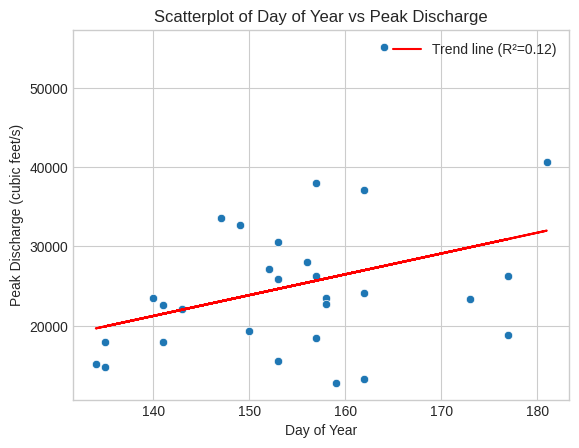

In [122]:
# Prepare the data
X = peak_discharge_dates['day_of_year'].values.reshape(-1, 1)
y = peak_discharge_dates['discharge_value'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict the values
y_pred = model.predict(X)

# Calculate the R-squared value
r2 = r2_score(y, y_pred)
print(f'R-squared: {r2}')

# Plot the scatter plot with the trend line
sns.scatterplot(data=peak_discharge_dates, x='day_of_year', y='discharge_value')
plt.plot(peak_discharge_dates['day_of_year'], y_pred, color='red', label=f'Trend line (R²={r2:.2f})')
plt.title('Scatterplot of Day of Year vs Peak Discharge')
plt.xlabel('Day of Year')
plt.ylabel('Peak Discharge (cubic feet/s)')
plt.legend()
plt.show()

It was thought that maybe there would be a correlation between the date of peak discharge and the value of peak discharge.  The logic being that years with a later peak dischareg would have a higher discharge.  This does not seem to be the case though.  

In [123]:
year_2021 = data[data['year'] == 2021]
year_2022 = data[data['year'] == 2022]
year_2023 = data[data['year'] == 2023]
year_2024 = data[data['year'] == 2024]
year_2025 = data[data['year'] == 2025]

In [124]:
year_2021

,date,discharge,snow_value,tmin,tmax,tavg,prcp,wesd,year,month,day,day_of_year
8823,2021-01-01,1242.395833,4.4,-145.0,-51.0,-93.0,0.0,1118.0,2021,1,1,1
8824,2021-01-02,1231.250000,4.7,-138.0,-42.0,-76.0,51.0,1194.0,2021,1,2,2
8825,2021-01-03,1270.416667,4.8,-115.0,-19.0,-51.0,0.0,1219.0,2021,1,3,3
8826,2021-01-04,1256.562500,5.1,-102.0,-16.0,-36.0,76.0,1295.0,2021,1,4,4
8827,2021-01-05,1271.562500,5.4,-95.0,-15.0,-45.0,102.0,1372.0,2021,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
9183,2021-12-27,818.833333,3.8,-183.0,-91.0,-115.0,25.0,965.0,2021,12,27,361
9184,2021-12-28,726.333333,3.9,-187.0,-133.0,-160.0,25.0,991.0,2021,12,28,362
9185,2021-12-29,627.166667,4.2,-166.0,-106.0,-138.0,76.0,1067.0,2021,12,29,363
9186,2021-12-30,623.666667,4.5,-148.0,-87.0,-111.0,76.0,1143.0,2021,12,30,364


In [125]:
discharge_2021 = year_2021[['day_of_year', 'discharge']]
discharge_2022 = year_2022[['day_of_year', 'discharge']]
discharge_2023 = year_2023[['day_of_year', 'discharge']]
discharge_2024 = year_2024[['day_of_year', 'discharge']]
discharge_2025 = year_2025[['day_of_year', 'discharge']]
discharge_3_year = discharge_2021.merge(discharge_2022, on='day_of_year').merge(discharge_2023, on='day_of_year')
discharge_3_year.columns = ['day_of_year', 'discharge_2021', 'discharge_2022', 'discharge_2023']

Text(0.5, 0, 'Day of the year')

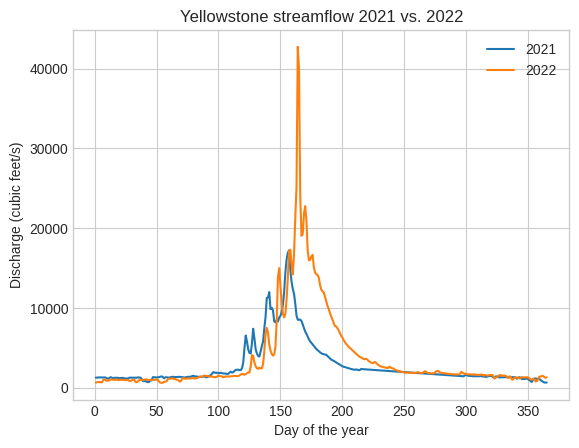

In [126]:
fig, ax = plt.subplots()
ax.plot(discharge_2021['day_of_year'], discharge_2021['discharge'], label='2021')
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
plt.legend()
plt.title('Yellowstone streamflow 2021 vs. 2022')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

This chart examines the 2021 vs the 2022 data.  There is quite a difference between the two.  2021's spring increase started earlier.  2022 had a much higher peak discharge than 2021.  I suspect that the amount of snowpack in the mountains was much less during 2021.  This is a potential future question to investigate.

Text(0.5, 0, 'Day of the year')

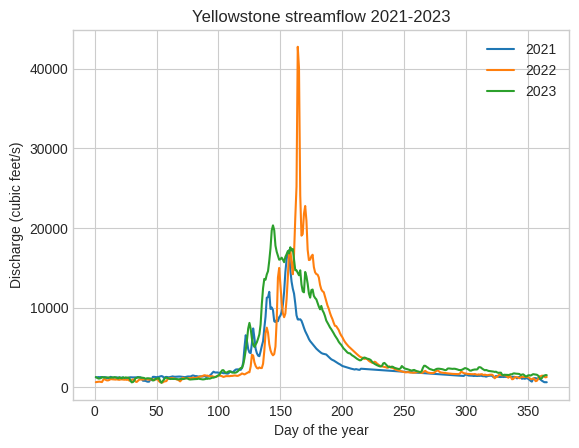

In [127]:
fig, ax = plt.subplots()
ax.plot(discharge_2021['day_of_year'], discharge_2021['discharge'], label='2021')
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
ax.plot(discharge_2023['day_of_year'], discharge_2023['discharge'], label='2023')
plt.legend()
plt.title('Yellowstone streamflow 2021-2023')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

Similar to the previous graph.  2023 data had a similar onset time as 2021.  The peak discharge is slightly more than 2021; bot not anywhere close to 2022.  

Text(0.5, 0, 'Day of the year')

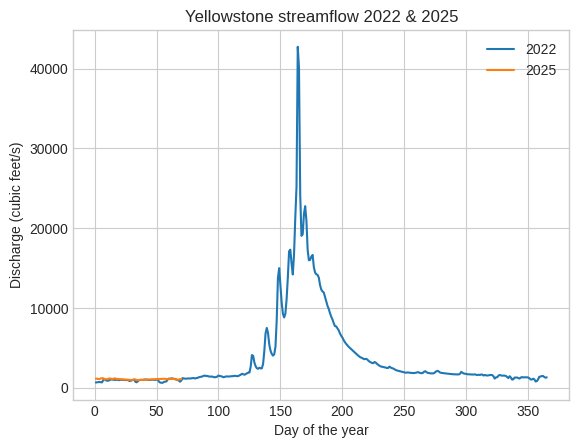

In [128]:
fig, ax = plt.subplots()
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
ax.plot(discharge_2025['day_of_year'], discharge_2025['discharge'], label='2025')
plt.legend()
plt.title('Yellowstone streamflow 2022 & 2025')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

It's hard to say how 2025 is progressing thus far

In [129]:
discharge=data['discharge'].to_frame()
discharge.index=data['date']

Text(0.5, 0, 'Date and Time(15 min intervals)')

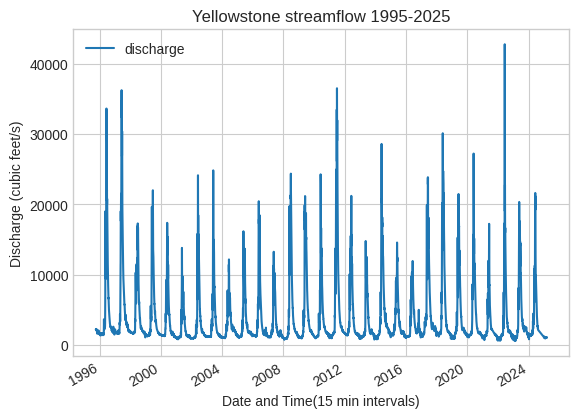

In [130]:

discharge.plot()
plt.title('Yellowstone streamflow 1995-2025')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date and Time(15 min intervals)')

In [131]:
discharge_2008 = discharge[(discharge.index >= '2008-01-01') & (discharge.index < '2009-01-01')]
discharge_2014 = discharge[(discharge.index >= '2014-01-01') & (discharge.index < '2015-01-01')]
discharge_2020 = discharge[(discharge.index >= '2020-01-01') & (discharge.index < '2021-01-01')]

Text(0.5, 0, 'Date')

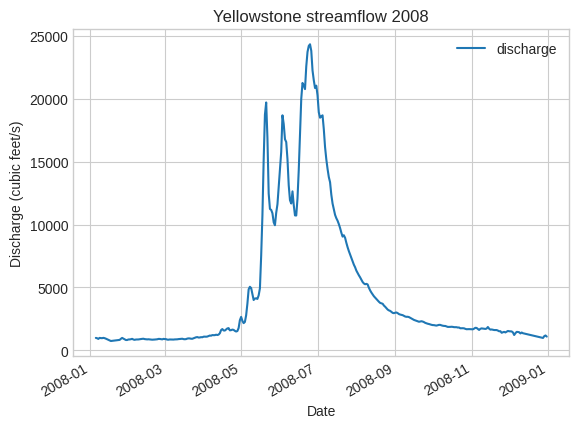

In [132]:
discharge_2008.plot()
plt.title('Yellowstone streamflow 2008')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

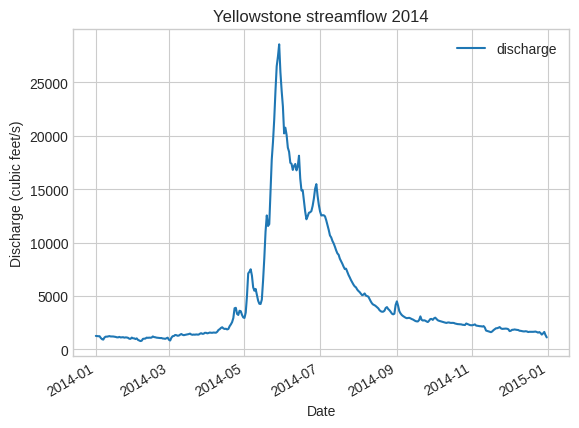

In [133]:
discharge_2014.plot()
plt.title('Yellowstone streamflow 2014')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

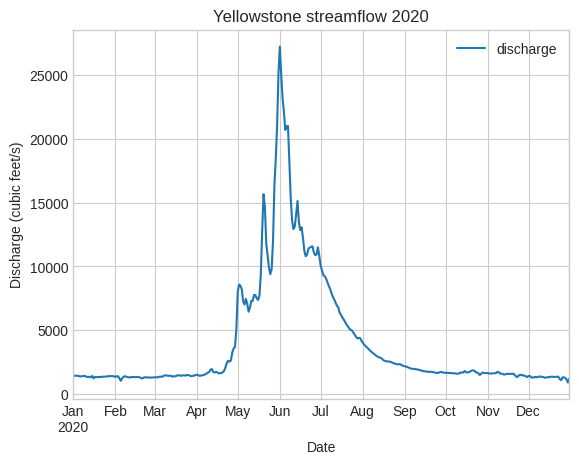

In [134]:
discharge_2020.plot()
plt.title('Yellowstone streamflow 2020')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

In [135]:
discharge['day_of_year'] = discharge.index.day_of_year
discharge['week'] = discharge.index.isocalendar().week.fillna(0).astype('int32')
discharge['month'] = discharge.index.month
discharge['quarter'] = discharge.index.quarter
discharge['year'] = discharge.index.year

In [136]:
discharge_consolidated = discharge.copy()
discharge_consolidated = discharge_consolidated.groupby(['year', 'day_of_year']).first()

([<matplotlib.axis.XTick at 0x73c44b5d23f0>,
 [Text(0, 0, '1'),
  Text(5, 0, '6'),
  Text(10, 0, '11'),
  Text(15, 0, '16'),
  Text(20, 0, '21'),
  Text(25, 0, '26'),
  Text(30, 0, '31'),
  Text(35, 0, '36'),
  Text(40, 0, '41'),
  Text(45, 0, '46'),
  Text(50, 0, '51')])

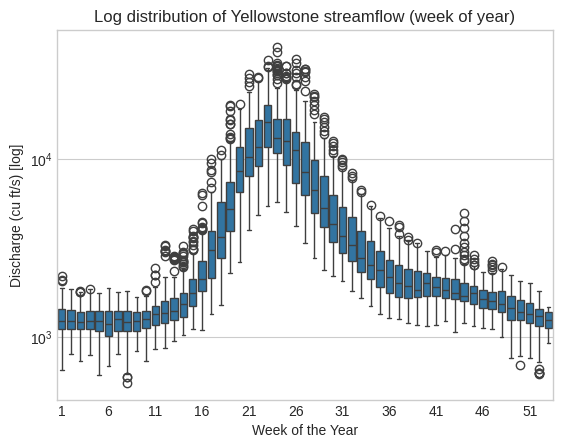

In [137]:
sns.boxplot(data=discharge_consolidated, x='week', y='discharge')
plt.ylabel('Discharge (cu ft/s) [log]')
plt.xlabel('Week of the Year')
plt.yscale('log')
plt.title('Log distribution of Yellowstone streamflow (week of year)')

plt.xticks(range(0, 53, 5))

Box and whisker plots for each week of the year.  There are many outliers during the spring and summer months.  This fits with what we already saw earlier that there is a lot of variability in the peak discharge for a given year.

Text(0.5, 1.0, 'Log distribution of Yellowstone streamflow (month of year)')

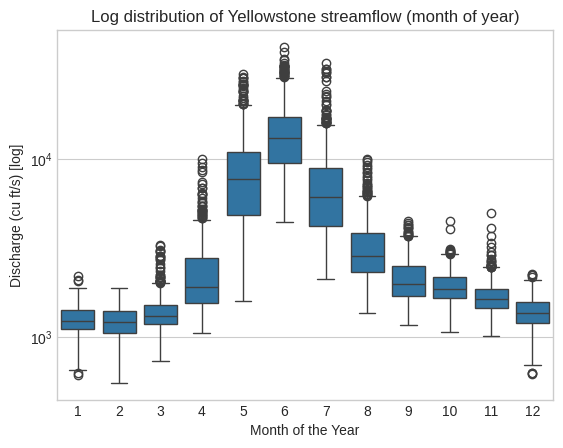

In [138]:
sns.boxplot(data=discharge_consolidated,x='month', y='discharge')
plt.ylabel('Discharge (cu ft/s) [log]')
plt.xlabel('Month of the Year')
plt.yscale('log')
plt.title('Log distribution of Yellowstone streamflow (month of year)')

Similar to the previous plot.  This plot is aggregating the data by month.  We can reach a similar conclusion though.  There is a lot of variability in the peak discharge for a given year.  Also, we can see some outliers during the winter months of December through February that are lower.  I wonder if this is due to very cold temperatures .

# Prediction
This is an effort to predict the spring increase in discharge.  The data is from the Yellowstone river at Livingston MT. The data is from the USGS and is available at https://waterdata.usgs.gov/mt/nwis/uv?site_no=06192500   

Ideally we would like to predict both the onset of the spring increase and the peak discharge.   

In [140]:
train = data[data['year'] < 2020]
test = data[data['year'] >= 2020]

In [141]:
data.head()


,date,discharge,snow_value,tmin,tmax,tavg,prcp,wesd,year,month,day,day_of_year
0,1995-10-01,2205.894737,0.0,-71.0,62.0,-1.0,0.0,0.0,1995,10,1,274
1,1995-10-02,2180.729167,0.0,-117.0,73.0,-21.0,0.0,0.0,1995,10,2,275
2,1995-10-03,2149.479167,0.4,-20.0,18.0,-3.0,102.0,102.0,1995,10,3,276
3,1995-10-04,2253.229167,0.4,-48.0,-2.0,-25.0,0.0,102.0,1995,10,4,277
4,1995-10-05,2241.770833,0.4,-99.0,24.0,-40.0,0.0,102.0,1995,10,5,278


KeyError: 'data'

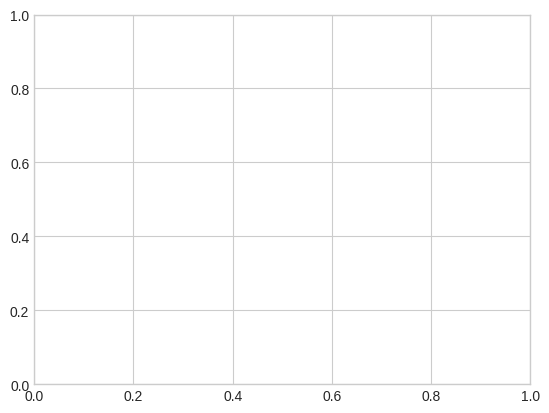

In [139]:
fig, ax = plt.subplots()
train['data'].plot(ax=ax)
test['data'].plot(ax=ax)
plt.legend(['Training Data', 'Test Data'])
plt.title('Training vs. Test Data for Streamflow Prediction')
plt.xlabel('Date')
plt.ylabel('Discharge (cu ft/s)')

The model will be trained on data from the years preceeding 2020.  The model will be tested on the 2020-2024 data.  

In [ ]:
features = ['month','week', 'day_of_year']
target = 'discharge'

x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [ ]:
# Remove NaN values from y_train and y_test
y_train = y_train.dropna()
y_test = y_test.dropna()

# Ensure x_train and x_test match the indices of y_train and y_test
x_train = x_train.loc[y_train.index]
x_test = x_test.loc[y_test.index]

regressor = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100)
eval_set = [(x_train, y_train), (x_test, y_test)]
regressor.fit(x_train, y_train, eval_set=eval_set, verbose=20)

In [ ]:
pd.set_option('mode.chained_assignment', None)

# Reindex x_test to match the index of test
x_test_reindexed = x_test.reindex(test.index)

# Make predictions
test['prediction'] = regressor.predict(x_test_reindexed)

In [ ]:
importance = pd.DataFrame(data=regressor.feature_importances_, index=regressor.feature_names_in_,
            columns=['importance'])
importance = importance.sort_values('importance')
importance.plot.barh()
plt.title('Feature Importance')

The day of the year is the most important variable in predicting the onset of the discharge.

In [ ]:
predicted_2023 = test[test['year'] == 2023]
predicted_2023.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2023 Discharge Data')

This is a plot of the model prediction vs the actual 2023 data.  The timing of the onset looks really good.  However, the peak discharge is off a bit.

In [ ]:
predicted_2024 = test[test['year'] == 2024]
predicted_2024.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2024 Discharge Data')

Like the 2023 data, the model prediction for the 2024 data looks good for the onset of the discharge.  The peak discharge is off a bit again.  It seems that the model is underpredicting the peak discharge.  I suspect that this has something to do with the amount of snowpack in the mountains.  This is a potential future question to investigate.  Average daily temperatures could also be a useful variable to include in the model.  This should be the next step in improving the model.

In [ ]:
# Drop rows with NaN values in 'discharge' or 'prediction' columns
test_clean = test.dropna(subset=['discharge', 'prediction'])

# Calculate the mean squared error
mse = sk.metrics.mean_squared_error(test_clean['discharge'], test_clean['prediction'])
print(f'Mean Squared Error: {mse}')
